In [1]:
#モジュールの読み込み
import matplotlib.pyplot as plt
from matplotlib import patches
import math
import numpy as np
import random
import pandas as pd
import itertools
import time
from IPython.display import clear_output
from deap import base
from deap import creator
from deap import tools
%matplotlib inline

## 長方形詰込み問題編

In [2]:
#設定
seed = 0
random.seed(seed)
np.random.seed(seed)

W, B, V = 4, 20, 25
wh = np.random.uniform(low=0.5, high=1.5, size=(B, 2))
wh = wh*(math.sqrt(V/np.sum(wh[:,0]*wh[:,1])))
xy = [[0,0]]*B

wh_df = pd.DataFrame(data=(wh),columns=("w","h"))
xy_df = pd.DataFrame(data=(xy),columns=("x","y"))
Rect_df = pd.concat([wh_df,xy_df],axis=1)

In [3]:
#Axesオブジェクトに長方形を配置
def Rect_place(rect,n):
    global ax,fig
    ax.grid()
    colors="#"+''.join([random.choice('0123456789ABCDEF') for i in range(3)])
    r = patches.Rectangle( xy=(rect.loc[n]["x"],rect.loc[n]["y"]) , width=rect.loc[n]["w"], height=rect.loc[n]["h"], color=colors)
    ax.add_patch(r)

class Rect():
    def __init__(self, x, y, w, h):
        self.x1 = x
        self.y1 = y
        self.x2 = x + w
        self.y2 = y + h
        self.w = w
        self.h = h
    
    def overlap(self, b):
        return max(self.x1, b.x1) < min(self.x2, b.x2) and max(self.y1, b.y1) < min(self.y2, b.y2)

    def subtract_by(self, b):
        if self.overlap(b):
            rooms = []
            if (self.x1 < b.x1 and b.x1 < self.x2) and max(self.y1, b.y1) < min(self.y2, b.y2):
                rooms.append(Rect(self.x1, self.y1, b.x1 - self.x1, self.h))

            if (self.x1 < b.x2 and b.x2 < self.x2) and max(self.y1, b.y1) < min(self.y2, b.y2):
                rooms.append(Rect(b.x2, self.y1, self.x2 - b.x2, self.h))

            if (self.y1 < b.y1 and b.y1 < self.y2) and max(self.x1, b.x1) < min(self.x2, b.x2) :
                rooms.append(Rect(self.x1, self.y1, self.w, b.y1 - self.y1))

            if (self.y1 < b.y2 and b.y2 < self.y2) and max(self.x1, b.x1) < min(self.x2, b.x2) :
                rooms.append(Rect(self.x1, b.y2, self.w, self.y2 - b.y2))
            return rooms
        
        else:
            return [self]

    def include(self, b):
        return self.x1 <= b.x1 and b.x2 <= self.x2 and self.y1 <= b.y1 and b.y2 <= self.y2

    def larger_than(self, w, h):
    # 座標は関係なく、図形として入るかどうか
        return w <= self.w and h <= self.h
    
def put_rect(input_rects, roomsORIG):
# 空白矩形と比較し、配置可能な空白を探索
    rects = []
    uniq_rooms = list(roomsORIG)
    for input_rect in input_rects:
        for i in range(len(uniq_rooms)):
            room = uniq_rooms[i]
            if room.larger_than(input_rect[0], input_rect[1]): #このrectに配置可能
                new_rect = Rect(room.x1, room.y1, input_rect[0], input_rect[1])
                rects.append(new_rect)
                break

        # すべての空白矩形から subtractする
        new_rooms = []
        for room in uniq_rooms:
            new_rooms += room.subtract_by(new_rect)
        new_rooms = sorted(new_rooms, key=lambda x:x.y1) # 結局総当たりするので意味ないが、将来効率化を考えソート

        # 重複削除 総当たり
        uniq_rooms = []
        for r_i in new_rooms:
            include_flg = False
            for r_j in new_rooms:
                if r_i == r_j: continue
                if r_j.include(r_i):
                    include_flg = True
                    break
            if not include_flg:
            # print("{} は他のどれにも含まれない".format(r_i))
                uniq_rooms.append(r_i)
        # 低い順（左にある順）に並び替え
        new_rooms = sorted(new_rooms, key=lambda a:a.x1)
        uniq_rooms = sorted(new_rooms, key=lambda a:a.y1)

    return (rects, uniq_rooms)

高さ：7.71


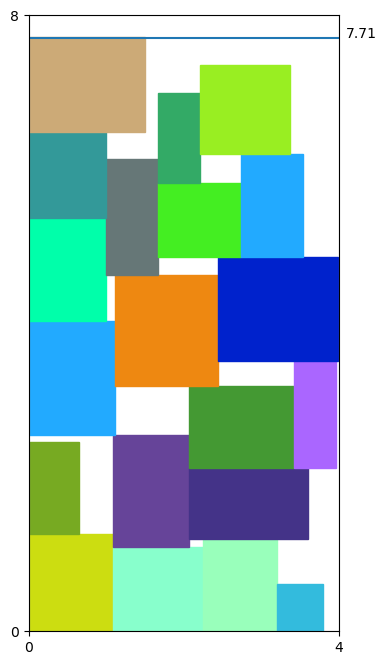

In [4]:
# 実行
Rect1 = Rect_df.copy()
img_list =  []
for i in range(B):
    img_list.append((Rect1.loc[i]["w"],Rect1.loc[i]["h"]))
rects, rooms = put_rect(img_list, roomsORIG=[Rect(0,0,W,100)])
x,y = [],[]
for rect in rects:
    x.append(rect.x1)
    y.append(rect.y1)
Rect1["x"] = x
Rect1["y"] = y

# 高さを定義
Height = round(max(Rect1["y"]+Rect1["h"]),2)
H = math.ceil(Height)
# Axesオブジェクトを作成
fig, ax = plt.subplots(figsize=(W,H))
ax.set_xticks([0, W])
ax.set_yticks([0, H])
ax.axhline(Height)
plt.text(4.1,Height,Height,size='10')
ax.grid()

for n in range(B):
    Rect_place(Rect1,n)
    
# 図形を描画
print(f"高さ：{Height}")
plt.show()

## GA編

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(B), B)
toolbox.register("individual", tools.initIterate, creator.Individual,toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [6]:
# 評価関数
def evalRect(individual):
    global B,Rect_df
    rect_df = Rect_df.copy()
    lst = individual
    # リスト順にdataを並び替え、行を再ラベリングする。
    rect_df = rect_df.reindex(index=lst)
    rect_df = rect_df.set_axis(list(np.arange(0, len(lst))), axis=0)
    img_list =  []
    for i in range(B):
        img_list.append((rect_df.loc[i]["w"],rect_df.loc[i]["h"]))
    rects, rooms = put_rect(img_list, roomsORIG=[Rect(0,0,W,100)])
    x,y = [],[]
    for rect in rects:
        x.append(rect.x1)
        y.append(rect.y1)
    rect_df["x"] = x
    rect_df["y"] = y
    # 最大値
    Height = round(max(rect_df["y"]+rect_df["h"]),2)
    return Height,

### 交叉
#### 部分写像交叉(PMX: Partially-mapped crossover)
　親の一方からは順番の一部をそのまま受け継ぎ，他の親からも残りの順番について、できるだけ多く親の順番を受け継ぐことを目的にしている。そのために，２つのランダムに選んだ切断点間の部分の順番を選び，以下に示す交叉を行う。
例えばつぎに示す２つの親の順番の交叉を考える。

　p1=(1 2 3 | 4 5 6 7 | 8 9)
　p2=(4 5 2 | 1 8 7 6 | 9 3)
 
まず縦棒 | にて示した２点で挟まれた部分を交叉するとつぎに示す子が得られる。ここで * は今のところ未決定であることを示す。

　c1=(* * * | 1 8 7 6 | * *)
　c2=(* * * | 4 5 6 7 | * *)
 
このことは次の入れ替えを定義していることにもなる。
- 1 <-> 4, 8 <-> 5, 7 <-> 6, 6 <-> 7

残りの未決定の部分について、既定のものと衝突を起こさないもの（即ち，既定のものに含まれないもの）はそのまま入れると、つぎの順番が得られる。

　c1=(* 2 3 | 1 8 7 6 | * 9)
　c2=(* * 2 | 4 5 6 7 | 9 3)

最後に残った部分には前記の入れ替えの定義を参照して衝突を起こさないように入れる。即ち、*c1*については１番目の * には1の代わりに4を入れ、８番目の * には8 の代わりに 5 を入れる。同様の操作を*c2*についても 行うと次の経路が得られる。

　o1=(4 2 3 | 1 8 7 6 | 5 9)
　o2=(1 8 2 | 4 5 6 7 | 9 3)
 
この方法は類似性と順序を保存している点に特徴がある。

### 突然変異
- 転座　ランダムに選んだ２つの順序を入れ替える。
- 挿入　ランダムに選んだ１つの番号を取り出してその位置を詰め、同じくランダムに   選んだ１つの番号の所に挿入し、それ以降をずらす。

今回選んだのは**転座**

In [8]:
# 評価関数、交差、突然変異、選択淘汰
toolbox.register("evaluate", evalRect)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selRoulette)

### 数値
交叉確率は50％\
突然変異確率は20％\
初期個体群は30\
世代数は50

In [9]:
def main():
    pop = toolbox.population(n=300)
    CXPB, MUTPB ,NGEN = 0.5, 0.2, 50
    clear_output(True)
    print("Start of evolution")

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    fits = [ind.fitness.values[0] for ind in pop]
    log_min = [min(fits)]
    log_max = [max(fits)]
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    log_mean = [mean]
    log_std = [std]
    
    print("  Evaluated %i individuals" % len(pop))
    
    for g in range(NGEN):
        
        
        print("-- Generation %i --" % g)

        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        print("  Evaluated %i individuals" % len(invalid_ind))

        pop[:] = offspring

        fits = [ind.fitness.values[0] for ind in pop]
        
        # 母集団の最小、最大、平均、標準偏差を表示
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        log_min.append(min(fits))
        log_max.append(max(fits))
        log_mean.append(mean)
        log_std.append(std)
        gen = list(range(0, NGEN+1))

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        
    print("-- End of (successful) evolution --")
    #clear_output()
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    return best_ind, gen, log_min, log_max, log_mean, log_std

In [10]:
t1 = time.time()
if __name__ == "__main__":
    best_ind, gen, log_min, log_max, log_mean, log_std = main()
t2 = time.time()
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time: .2f}秒")

Start of evolution
  Evaluated 300 individuals
-- Generation 0 --
  Evaluated 157 individuals
  Min 7.15
  Max 8.95
  Avg 8.0091
  Std 0.39022496503079773
-- Generation 1 --
  Evaluated 182 individuals
  Min 7.15
  Max 9.13
  Avg 8.023900000000001
  Std 0.3780684990844292
-- Generation 2 --
  Evaluated 195 individuals
  Min 7.15
  Max 9.25
  Avg 7.992799999999996
  Std 0.3817540569529192
-- Generation 3 --
  Evaluated 181 individuals
  Min 7.03
  Max 8.99
  Avg 8.0376
  Std 0.3911541554596001
-- Generation 4 --
  Evaluated 194 individuals
  Min 7.19
  Max 9.01
  Avg 8.048066666666658
  Std 0.3697957934982763
-- Generation 5 --
  Evaluated 196 individuals
  Min 7.09
  Max 9.06
  Avg 8.033533333333331
  Std 0.3992929361870535
-- Generation 6 --
  Evaluated 196 individuals
  Min 7.26
  Max 9.35
  Avg 7.9922666666666675
  Std 0.40061726816942006
-- Generation 7 --
  Evaluated 178 individuals
  Min 6.9
  Max 9.35
  Avg 8.017000000000005
  Std 0.4073241952056522
-- Generation 8 --
  Evaluate

高さ：6.85


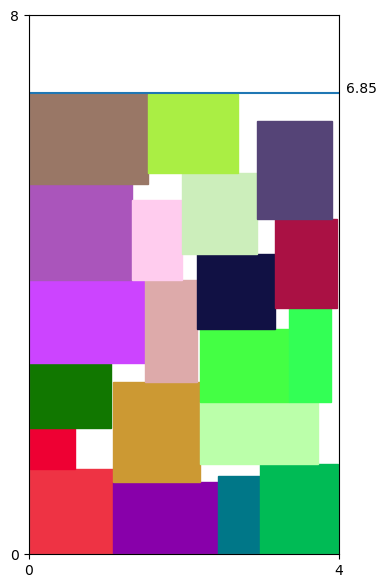

In [10]:
#描画
lst = best_ind

Rect2 = Rect_df.copy()
Rect2 = Rect2.reindex(index=lst)
Rect2 = Rect2.set_axis(list(np.arange(0, len(lst))), axis=0)

img_list =  []
for i in range(B):
    img_list.append((Rect2.loc[i]["w"],Rect2.loc[i]["h"]))
rects, rooms = put_rect(img_list, roomsORIG=[Rect(0,0,W,100)])
x,y = [],[]
for rect in rects:
    x.append(rect.x1)
    y.append(rect.y1)
Rect2["x"] = x
Rect2["y"] = y

# 高さを定義
Height = round(max(Rect2["y"]+Rect2["h"]),2)
H = math.ceil(Height)

#Axesオブジェクトを作成
fig, ax = plt.subplots(figsize=(W,H))
ax.set_xticks([0, W])
ax.set_yticks([0, H+1])
ax.axhline(Height)
plt.text(4.1,Height,Height,size='10')
ax.grid()
    
for n in range(B):
    Rect_place(Rect2,n)
    
#図形を描画
print(f"高さ：{Height}")
plt.show()

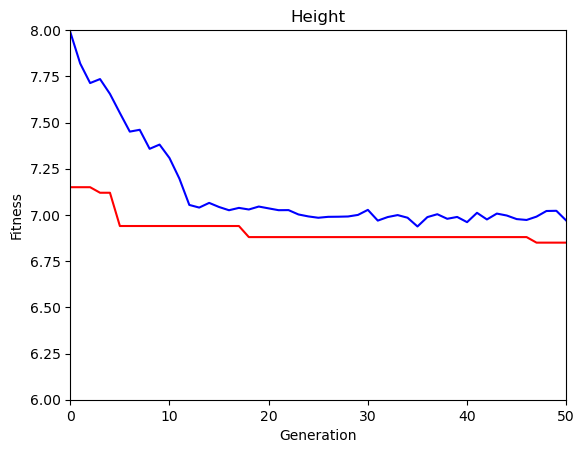

In [11]:
#描画2
x = gen
y1 = log_min
y2 = log_max
y3 = log_mean
y4 = log_std

fig, ax = plt.subplots()
plt.xlim(0,len(x)-1)
plt.ylim(6,H+1)
ax.plot(x, y1,"r", y3,"b")

plt.title("Height")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")

plt.show()